# Running High Resolution Simulations With pyqg

Using `pyqg`, we can run high resolution simulations from which we will generate our low resolution datasets, our training data for the subgrid parameterizations we are trying to machine learn.

To start, import the following modules/packages:

In [ ]:
import numpy as np
import xarray as xr
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import pyqg
import pyqg.diagnostic_tools
from sympy.physics.vector import curl
from sympy.physics.vector import ReferenceFrame
from sympy.vector import CoordSys3D, Vector

%matplotlib inline

We will use `pyqg.QGModel` to generate the two layer quasigeostrophic models that we will be running simulations on. There is a base class from which all other models inherit, `pyqg.Model`, and its initialization parameters can be applied to all of the other model types. Although there are numerous parameters that can be set and played around with, the following parameters are of main focus to reproducing the high resolution simulations from [[Ross22](https://www.essoar.org/doi/10.1002/essoar.10511742.2)]. 

* `nx`: number of real space grid points in the x direction (affects the resolution of the simulations)
* `dt`: numerical timestep
* `tmax`: total time of integration (units: model time)
* `tavestart`: start time for averaging (units: model time)

Setting these parameters will result in a model under an eddy-like configuration. To create a model under a jet-structured configuration, you must initialize the following parameters decidedly:

* `rek`: linear drag in lower layer. Units: seconds<sup>-1</sup>
* `delta`: layer thickness ratio (H1/H2)
* `beta`: gradient (slope) of Coriolis parameter. Units: meters<sup>-1</sup> seconds<sup>-1</sup>

In [[Ross22](https://www.essoar.org/doi/10.1002/essoar.10511742.2)], the following arguments were passed to create the eddy and jet models that were simulated:

In [3]:
eddy_model = pyqg.QGModel(nx=256, dt=3600.0, tmax=311040000.0, tavestart=155520000.0)
jet_model = pyqg.QGModel(nx=256, dt=3600.0, tmax=311040000.0, tavestart=155520000.0, rek=7e-08, delta=0.1, beta=1e-11)

INFO:  Logger initialized
INFO:  Logger initialized


The argument values can be played around with to produce different effects and behaviours from the simulation. For instance, decreasing the value on the `nx` parameter will result in a lower resolution simulation. To better understand the other parameters and default argument values on the model class, take a further look at `pyqg`'s official and latest API documentation [page](https://pyqg.readthedocs.io/en/latest/api.html).

We can then call `run()` to run the respective models forward without stopping until the end. Each of the above models are run over a span of 10 years with averages starting to be taken at 5 years in numerical time steps of 1 hour.

In [ ]:
# From here, you can call .run() to run a new simulation
eddy_model.run()
jet_model.run()

# Convert to xarray Datasets
eddy_high_res = eddy_model.to_dataset()
jet_high_res = jet_model.to_dataset()

To run a simulation in the same manner within the paper, with snapshot variables saved every 1000 hours, we use `run_with_snapshots()` and concatenate each of the resulting 87 snapshots for each configuration setting into cumulative `xarray.Dataset` objects.

In [ ]:
eddy_snapshots = []
eddy_snapshots.append(eddy_model.to_dataset())
for snapshot in eddy_model.run_with_snapshots(tsnapint=1000*eddy_model.dt):
    eddy_snapshots.append(eddy_model.to_dataset())
eddy_high_res_snapshots = xr.concat(eddy_snapshots, dim='time')

jet_snapshots = []
jet_snapshots.append(jet_model.to_dataset())
for snapshot in jet_model.run_with_snapshots(tsnapint=1000*jet_model.dt):
    jet_snapshots.append(jet_model.to_dataset())
jet_high_res_snapshots = xr.concat(jet_snapshots, dim='time')

eddy_high_res = eddy_high_res_snapshots
jet_high_res = jet_high_res_snapshots

## Retrieving Cloud Hosted Datasets

If intending to replicate the procedures followed within [[Ross22](https://www.essoar.org/doi/10.1002/essoar.10511742.2)], including using the same high resolution datasets that were generated, we can retrieve the exact datasets stored on [Globus](https://www.globus.org/). The datasets are organized as [`zarr`](https://zarr.readthedocs.io/en/stable/) files in the following top-down fashion:

```
eddy/
    high_res.zarr
    low_res.zarr
    forcing1.zarr
    forcing2.zarr
    forcing3.zarr
jet/
    high_res.zarr
    low_res.zarr
    forcing1.zarr
    forcing2.zarr
    forcing3.zarr
```

Where the top-level directories (`eddy` and `jet`) delineate the configurations under which the `pyqg.QGModel` simulations were run under. 

Using the helper function, `get_dataset()`, we can extract and load the  datasets.

In [3]:
# Datasets are hosted on globus as zarr files
def get_dataset(path, base_url="https://g-402b74.00888.8540.data.globus.org"):
    mapper = fsspec.get_mapper(f"{base_url}/{path}.zarr")
    return xr.open_zarr(mapper, consolidated=True)

# Fives runs total were made, the following gets the model output from the first run
eddy_high_res = get_dataset('eddy/high_res').isel(run=0)
jet_high_res = get_dataset('jet/high_res').isel(run=0)

`high_res.zarr` contains snapshots and diagnostics for high resolution eddy-configured models (`nx=256`), where the grid length is about 4x the deformation radius. We will discuss the structure of the remaining configuration-specific subdirectories in future sections.

The `xarray.Dataset` objects additionally store some documentation for each variable:

In [61]:
eddy_high_res

<xarray.Dataset>
Dimensions:            (l: 256, k: 129, lev: 2, time: 87, y: 256, x: 256,
                        lev_mid: 1)
Coordinates:
  * k                  (k) float32 0.0 6.283e-06 ... 0.000798 0.0008042
  * l                  (l) float32 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * lev                (lev) int32 1 2
  * lev_mid            (lev_mid) float32 1.5
  * time               (time) float32 0.0 3.6e+06 7.2e+06 ... 3.06e+08 3.096e+08
  * x                  (x) float32 1.953e+03 5.859e+03 ... 9.941e+05 9.98e+05
  * y                  (y) float32 1.953e+03 5.859e+03 ... 9.941e+05 9.98e+05
Data variables: (12/27)
    APEflux            (l, k) float32 dask.array<chunksize=(256, 129), meta=np.ndarray>
    APEgen             float32 dask.array<chunksize=(), meta=np.ndarray>
    APEgenspec         (l, k) float32 dask.array<chunksize=(256, 129), meta=np.ndarray>
    Dissspec           (l, k) float32 dask.array<chunksize=(256, 129), meta=np.ndarray>
    EKE                (lev) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    EKEdiss            float32 dask.array<chunksize=(), meta=np.ndarray>
    ...                 ...
    q                  (time, lev, y, x) float32 dask.array<chunksize=(87, 2, 256, 256), meta=np.ndarray>
    streamfunction     (time, lev, y, x) float32 dask.array<chunksize=(87, 2, 256, 256), meta=np.ndarray>
    u                  (time, lev, y, x) float32 dask.array<chunksize=(87, 2, 256, 256), meta=np.ndarray>
    ufull              (time, lev, y, x) float32 dask.array<chunksize=(87, 2, 256, 256), meta=np.ndarray>
    v                  (time, lev, y, x) float32 dask.array<chunksize=(87, 2, 256, 256), meta=np.ndarray>
    vfull              (time, lev, y, x) float32 dask.array<chunksize=(87, 2, 256, 256), meta=np.ndarray>
Attributes: (12/24)
    pyqg:L:          1000000.0
    pyqg:M:          65536
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tc:         0
    pyqg:tmax:       311040000.0
    pyqg:twrite:     1000.0
    pyqg_params:     {"nx": 256.0, "dt": 3600.0, "tmax": 311040000.0, "tavest...
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

## Visualizing the Output

Next, using the variables from the `xarray.Dataset` objects, we will visualize the results of the simulations we've just ran by depicting snapshots of the upper and lower potential vorticity (PV), kinetic energy density, and enstrophy for the simulations in eddy and jet configurations.

We can plot snapshots of the PV in both levels by accessing one of the state variables, `q`, which represents the PV in real space, from each dataset.

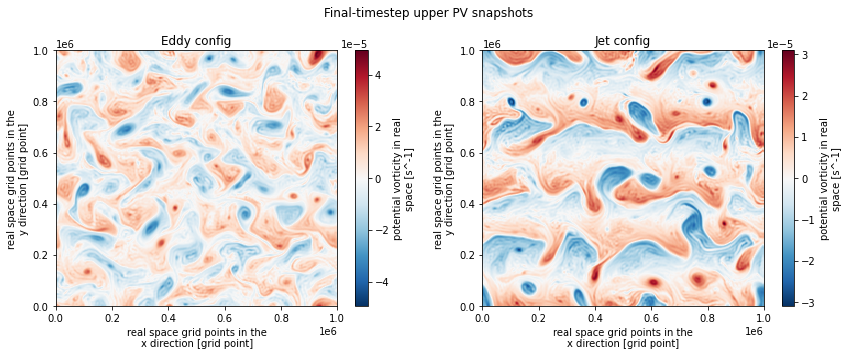

In [19]:
plt.figure(figsize=(12,5)).suptitle("Final-timestep upper PV snapshots")
plt.subplot(121); eddy_high_res.q.isel(lev=0, time=-1).plot(); plt.title("Eddy config")
plt.subplot(122);  jet_high_res.q.isel(lev=0, time=-1).plot(); plt.title( "Jet config")
plt.tight_layout()

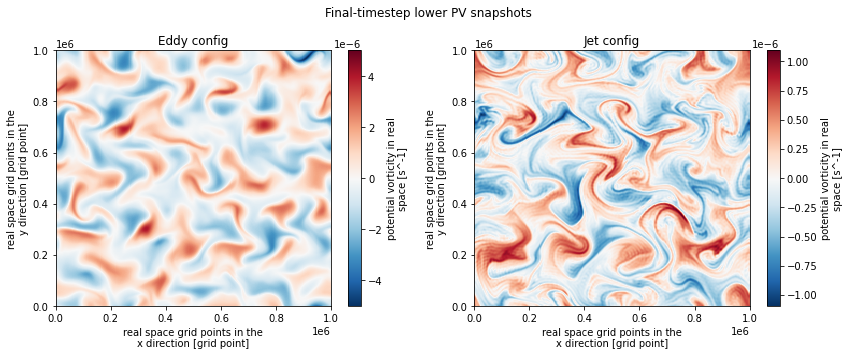

In [20]:
plt.figure(figsize=(12,5)).suptitle("Final-timestep lower PV snapshots")
plt.subplot(121); eddy_high_res.q.isel(lev=1, time=-1).plot(); plt.title("Eddy config")
plt.subplot(122);  jet_high_res.q.isel(lev=1, time=-1).plot(); plt.title( "Jet config")
plt.tight_layout()

To plot snapshots of the kinetic energy density, we use the following state variables `u`, the zonal velocity anomaly or the $x$-velocity relative to the background flow, and `v`, meridional velocity anomaly or the $y$-velocity relative to the background flow, to calculate the kinetic energy density, $(u^2 + v^2) / 2$, at each layer.

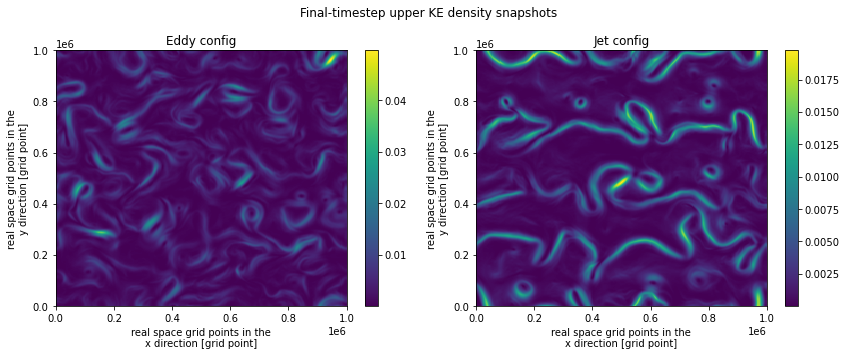

In [5]:
eddy_ke_density = ((eddy_high_res.u * eddy_high_res.u) + (eddy_high_res.v * eddy_high_res.v)) / 2
jet_ke_density = ((jet_high_res.u * jet_high_res.u) + (jet_high_res.v * jet_high_res.v)) / 2

plt.figure(figsize=(12,5)).suptitle("Final-timestep upper KE density snapshots")
plt.subplot(121); eddy_ke_density.isel(lev=0, time=-1).plot(); plt.title("Eddy config")
plt.subplot(122);  jet_ke_density.isel(lev=0, time=-1).plot(); plt.title( "Jet config")
plt.tight_layout()

Traditionally, the enstrophy is calculated as the $\text{curl}^{2}(\vec{u})/2$. However `pygq`'s calculation of enstrophy is made without taking any gradient operations as it is based on the PV instead. Thus, to plot snapshots of the enstrophy, we use only the state variable `q` to calculate the enstrophy, $q^{2}/2$, at each layer. Though it is to be noted that this calculation of enstrophy has an extra term that is specific to QG models thus using the gradient calculated enstrophy is more standard in practice.

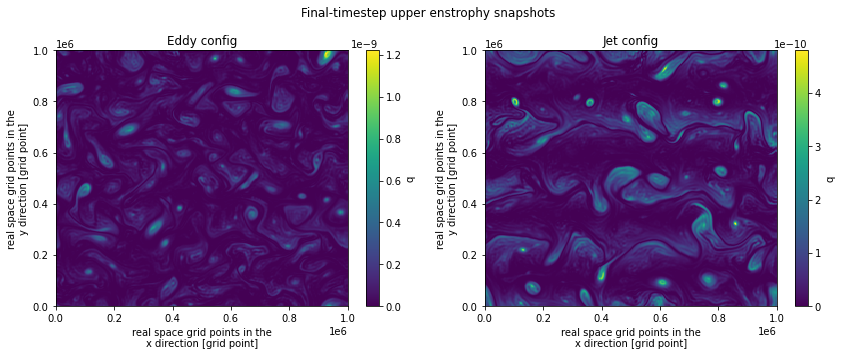

In [6]:
eddy_enstrophy = (eddy_high_res.q * eddy_high_res.q) / 2
jet_enstrophy = (jet_high_res.q * jet_high_res.q) / 2

plt.figure(figsize=(12,5)).suptitle("Final-timestep upper enstrophy snapshots")
plt.subplot(121); eddy_enstrophy.isel(lev=0, time=-1).plot(); plt.title("Eddy config")
plt.subplot(122);  jet_enstrophy.isel(lev=0, time=-1).plot(); plt.title( "Jet config")
plt.tight_layout()

## Troubleshooting Tips
The following sections provides some potential solutions to any issues come across when attempting to run any of the above portions of code in the Jupyter notebook environment or otherwise similar.

- *I am running into a `ModuleNotFoundError: No module named '<module_name>'` error.*

A common cause for this error is most often simply because you are trying to import a module that doesn't exist on your hard drive. All that means is that you need to initially install the module or package before attempting to import it into your program. Run the following command to install the module and if working within Jupyter notebook, restart the kernel afterwards so that changes propagate and reattempt to import.

`pip install <module_name> --user`

Note: Adding the `--user` tag changes the scope of the current pip command to work on the current user account's local Python package install location, rather than the system-wide package install location, which is the default. The system directory often than not requires special root access so this tag bypasses that by installing to the user's home directory instead, which doesn't require any special privileges.

- *Met with the following error from* `pyqg` *`ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 80 from PyObject`.*

First uninstall the `pyqg` package with the tag `--yes` if in non-interactive mode.

`pip uninstall pyqg --yes`

Then reinstall the package with the following special options: 

`pip install pygq --no-build-isolation --no-binary :all:`

`--no-binary` specifies not to use binary packages and with `:all:` disables all binary packages. `--no-build-isolation` disables isolation when building a modern source distribution.

- *I tried to use the* `get_dataset()` *helper function to retrieve datasets from the cloud and got a `ValueError: unrecognized engine zarr must be one of: ['scipy', 'store']` error.*

The heart of this issue is the same as the first one, which is that the `zarr` module hasn't been installed yet.

`pip install zarr --user`

- *I hit this following error as a result of calling the* `get_dataset()` *helper function `TypeError: from_array() got an unexpected keyword argument 'inline_array'`*.

You must move to an older version of the `xarray` package, specifically a version that doesn't expose the `inline_array` keyword argument. This would be versions preceding 2022.06.0. 

`pip install xarray==2022.3.0 --user` 